In [24]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from astropy.table import Table
from astropy.stats import LombScargle
import exoplanet as xo

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})


In [5]:
# AU Mic == TIC 441420236
file = 'tess2018206045859-s0001-0000000441420236-0120-s_lc.fits'
tbl = Table.read(file, format='fits')

In [30]:
AOK = (tbl['QUALITY'] == 0) & np.isfinite(tbl['PDCSAP_FLUX'])

df_tbl = tbl.to_pandas()
smo = df_tbl['PDCSAP_FLUX'][AOK].rolling(128, center=True).median()

med = np.nanmedian(df_tbl['PDCSAP_FLUX'][AOK])

acf = xo.autocorr_estimator(tbl['TIME'][AOK], tbl['PDCSAP_FLUX'][AOK] / med,
                                        yerr=tbl['PDCSAP_FLUX_ERR'][AOK] / med,
                                        min_period=0.1, max_period=27, max_peaks=2)
acf_per = acf['peaks'][0]['period']

s_window = int(acf_per / np.abs(np.nanmedian(np.diff(tbl['TIME']))) / 10.)
smo = df_tbl['PDCSAP_FLUX'][AOK].rolling(s_window, center=True).median()

print('ACF Period: '+str(acf_per))

ACF Period: 4.8373145159062005


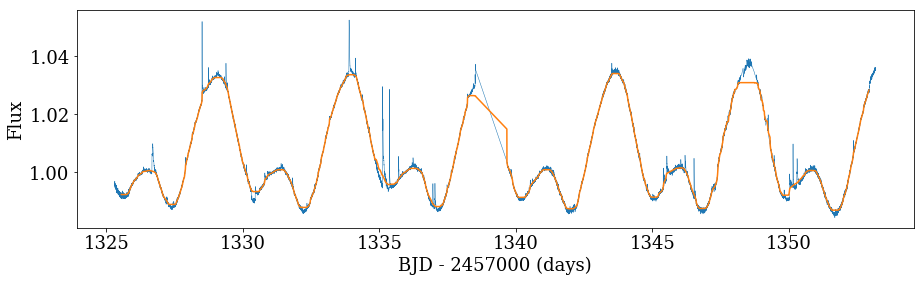

In [35]:
plt.figure(figsize=(15,4))
plt.plot(tbl['TIME'][AOK], tbl['PDCSAP_FLUX'][AOK]/med, lw=0.5)
plt.plot(tbl['TIME'][AOK], smo/med)
plt.ylabel('Flux');
plt.xlabel('BJD - 2457000 (days)');

In [33]:
# Lomb Scargle, for completeness
LS = LombScargle(df_tbl['TIME'][AOK], df_tbl['PDCSAP_FLUX'][AOK] / med, 
                 dy=df_tbl['PDCSAP_FLUX_ERR'][AOK]/med)

frequency, power = LS.autopower(minimum_frequency=1./40., 
                                maximum_frequency=1./0.1, 
                                samples_per_peak=7)
best_frequency = frequency[np.argmax(power)]

LS_per = 1./best_frequency

print('L-S Period: '+str(LS_per))

L-S Period: 4.8914555773148995


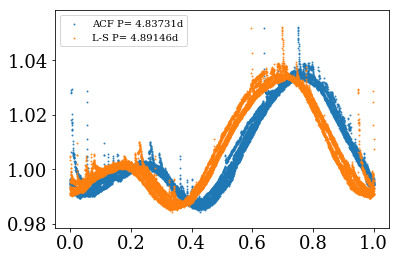

In [48]:
plt.scatter((df_tbl['TIME'][AOK] % acf_per ) / acf_per, df_tbl['PDCSAP_FLUX'][AOK] / med, 
            s=1, alpha=0.8, label='ACF P='+format(acf_per,'8.5f')+'d')

plt.scatter((df_tbl['TIME'][AOK] % LS_per ) / LS_per, df_tbl['PDCSAP_FLUX'][AOK] / med, 
            s=1, alpha=0.8, label='L-S P='+format(LS_per,'8.5f')+'d')

plt.legend(fontsize=10)

# I like the ACF period - phase-folded is a bit tighter, and closer to the literature values of ~4.85d

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


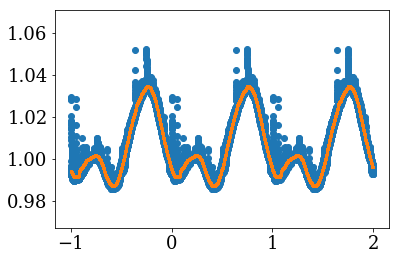

In [113]:
# now remove the flares via phase-folded median
phase = (df_tbl['TIME'][AOK] % acf_per) / acf_per
ss = np.argsort(phase)

phase_flux = np.tile(df_tbl['PDCSAP_FLUX'][AOK][ss] / med, 3)
phase_2 = np.concatenate((phase[ss]-1, phase[ss], phase[ss]+1))
time_2 = np.tile(df_tbl['TIME'][AOK][ss], 3)
err_2 = np.tile(df_tbl['PDCSAP_FLUX_ERR'][AOK][ss]/ med, 3)


ss2 = np.argsort(phase_2)
phase_flux = phase_flux[ss2]
phase_2 = phase_2[ss2]
time_2 = time_2[ss2]
err_2 = err_2[ss2]

phase_med = pd.Series(phase_flux).rolling(256, center=True).median()

plt.scatter(phase_2, phase_flux)
plt.scatter(phase_2, phase_med, s=3)
# plt.xlim(0,1)


(14422,)


(0, 1)

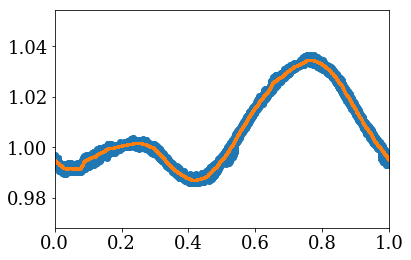

In [117]:
no_fl = np.where((phase_2 > 0) & (phase_2 <= 1) & 
                 ((phase_flux - phase_med) < 10*np.nanmedian(err_2)))[0]
print(no_fl.shape)

plt.scatter(phase_2[no_fl], phase_flux[no_fl])
plt.scatter(phase_2, phase_med, s=3)
plt.xlim(0,1)


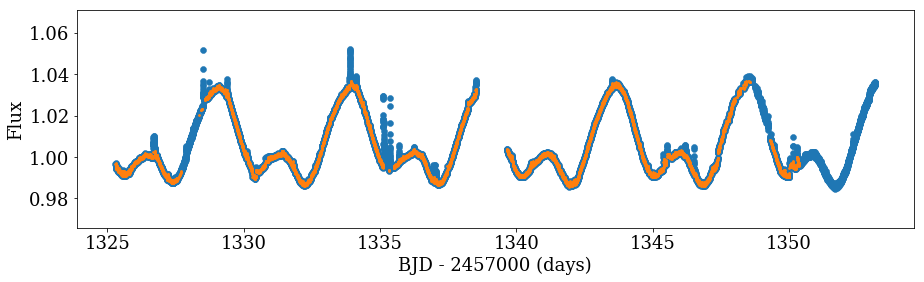

In [118]:
plt.figure(figsize=(15,4))

plt.scatter(df_tbl['TIME'].values[AOK],
            df_tbl['PDCSAP_FLUX'].values[AOK]/med, lw=0.5)

plt.scatter(time_2[no_fl], phase_flux[no_fl], s=3)

plt.ylabel('Flux');
plt.xlabel('BJD - 2457000 (days)');

In [119]:
# output light curve for STSP

ssout = np.argsort(time_2[no_fl])

df_out = pd.DataFrame(data={'time':time_2[no_fl][ssout], 
                            'flux':phase_flux[no_fl][ssout], 
                            'err':err_2[no_fl][ssout]})
df_out.to_csv('tess_lc.dat', index=False, index_label=False, 
              columns=['time', 'flux', 'err'], sep=' ', header=False)

In [120]:
# print some values to use in .in file:

print(acf_per)
print(min(time_2[no_fl]))
print(max(time_2[no_fl]) - min(time_2[no_fl]))
print(max(phase_flux[no_fl]))

4.8373145159062005
1325.3028134918275
25.064856457668157
1.0366201
